In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(42)

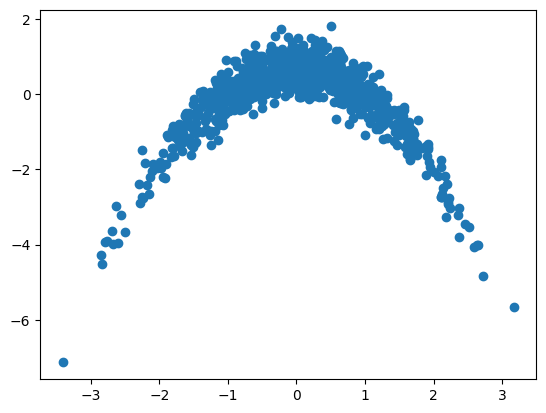

In [2]:
# target distribution q_D
N = 1000
Xs = np.random.randn(2 * N).reshape(N, 2)
Xs[:, 1] -= 2 * Xs[:, 0] ** 2
# it is alweays a good idea for diffusion to normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs, axis=0).reshape(1, -1)) / np.std(Xs, axis=0).reshape(1, -1)
plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.show()

In [3]:
# neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience
# note that this networks expects normalized values of t in 0 to 1. so divide your time index by T.
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features = num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        # We assume that t is a n-dimensional vector with values in [0,1]
        # each element in t gives the time for each element in the batch
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(
            0, 3, num_frequencies, device=t.device, dtype=t.dtype
        )
        cos_feats = torch.cos(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        sin_feats = torch.sin(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        return torch.hstack([cos_feats, sin_feats])

    def forward(self, x, t):
        t_embedding = self.embedding(t)
        # Create sinusoidal features and apply the silu activation
        t_embedding = torch.nn.functional.silu(self.embedding(t))

        # linear combination of space and time features
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        # now apply a simple feed forward network with relu activations.
        # note: we skip dropout for simplicity.
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        # transform back
        x = self.fc_out(x)
        return x

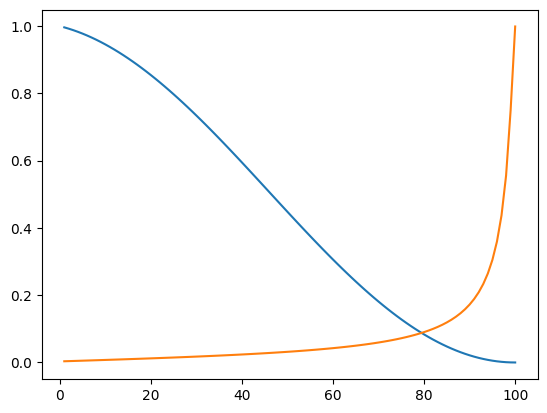

In [5]:
# Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
# As beta we use the scheme proposed in the lecture
T = 100
ts = np.linspace(0, 1, T + 1)
s = 0.08
gs = np.cos(np.pi / 2 * ((ts + s) / (1 + s))) ** 2
betas = np.minimum(1 - gs[1:] / gs[:-1], 0.999)
alpha = 1 - betas
alpha_cumprod = np.cumprod(alpha)


def alpha_bar(t):
    return alpha_cumprod[t - 1]


def beta(t):
    return betas[t - 1]


def sample_t():
    return torch.randint(1, T + 1, (1,)).item()


# simpler scheme with fixed beta for comparison
# betas = 0.05*np.ones(T)
t_range = np.arange(1, T + 1)
plt.plot(t_range, [alpha_bar(t) for t in t_range], label="alpha_bar")
plt.plot(t_range, [beta(t) for t in t_range], label="beta")


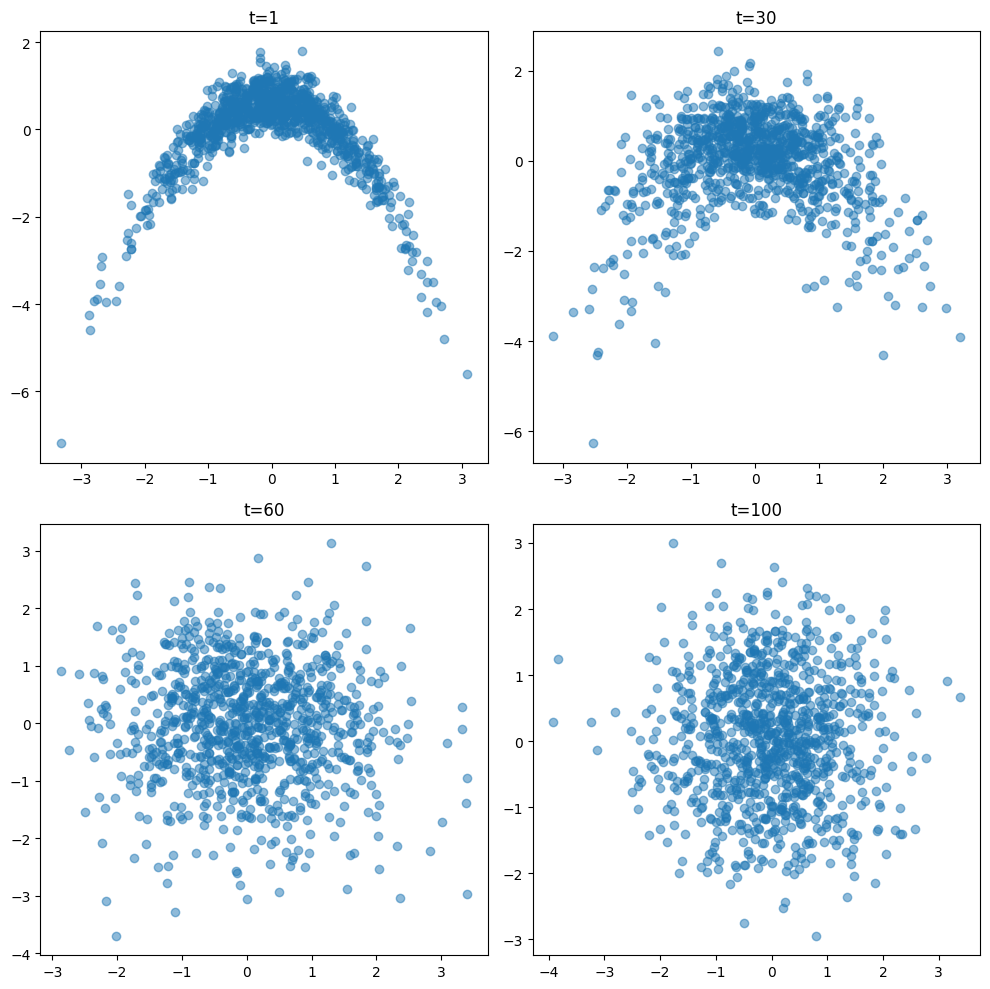

In [6]:
def get_xt(x_0, t, eps):
    return np.sqrt(alpha_bar(t)) * x_0 + np.sqrt(1 - alpha_bar(t)) * eps


# plot the generating distribution q(X_t) for different t=0,30,60,100
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
t_values = [1, 30, 60, 100]
for i, t in enumerate(t_values):
    eps = np.random.randn(N, 2)
    X_t = get_xt(Xs, t, eps)
    ax = axs[i // 2, i % 2]
    ax.scatter(X_t[:, 0], X_t[:, 1], alpha=0.5)
    ax.set_title(f"t={t}")
plt.tight_layout()
plt.show()

In [7]:
# Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
# implement by sampling a random time step t in 0,..,T
# params:
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.


def loss(Xs, model):
    # Sample a random time step t
    t = torch.randint(1, T + 1, (1,))  # t in 1,...,T
    # generate random noise in the shape of Xs
    eps = torch.randn_like(Xs)
    # Get the x_t
    x_t = get_xt(Xs, t.item(), eps)

    t_normalized = torch.div(t, T)
    # Predict the noise using the model
    eps_theta = model(x_t, t_normalized)

    # Compute the L2 norm between the true noise and the predicted noise
    loss = torch.norm(eps - eps_theta, p=2, dim=1).sum()
    # if t == 100:
    #    print(loss)
    return loss

epoch: 0
loss: 1055.8569576740265
epoch: 50
loss: 593.3867651820183
epoch: 100
loss: 661.0854987502098
epoch: 150
loss: 685.0869033932686
epoch: 200
loss: 675.369133234024
epoch: 250
loss: 636.8213747739792
epoch: 300
loss: 608.5387082695961
epoch: 350
loss: 625.8388502597809
epoch: 400
loss: 626.8876472115517
epoch: 450
loss: 708.8591563105583


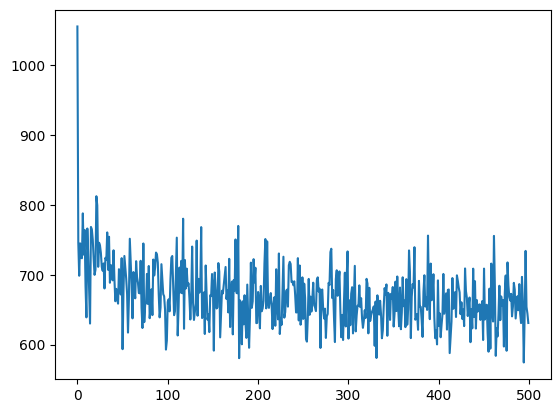

In [8]:
# train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(
    torch.tensor(Xs, dtype=torch.float32), batch_size=10
)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
num_epochs = 500
losses = []
for e in range(num_epochs):
    loss_epoch = 0
    if e % (num_epochs // 10) == 0:
        print("epoch:", e)
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data, model)
        l.backward()
        loss_epoch += l.item()
        optimizer.step()
    if e % (num_epochs // 10) == 0:
        print("loss:", loss_epoch)
    losses.append(loss_epoch)
plt.plot(losses)

In [9]:
t = 100
print(1 / np.sqrt(1 - beta(t)) * (beta(t) / np.sqrt(1 - alpha_bar(t))))
print((beta(t) / np.sqrt(1 - alpha_bar(t))))


31.59115721188728
0.9990001071001836


In [10]:
1 - beta(t)

0.0010000000000000009

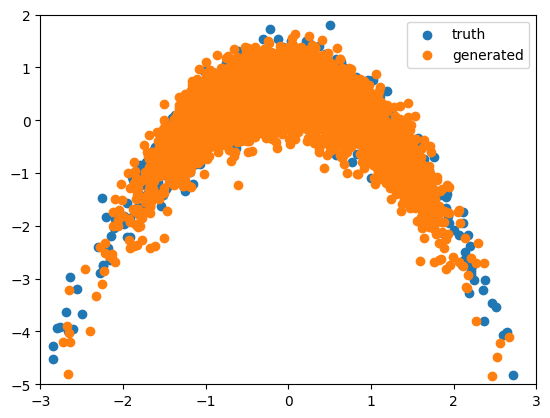

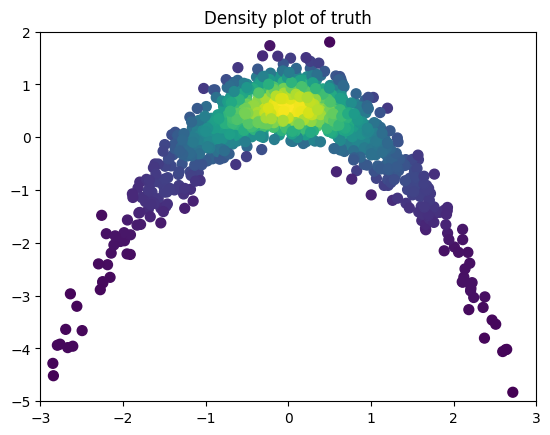

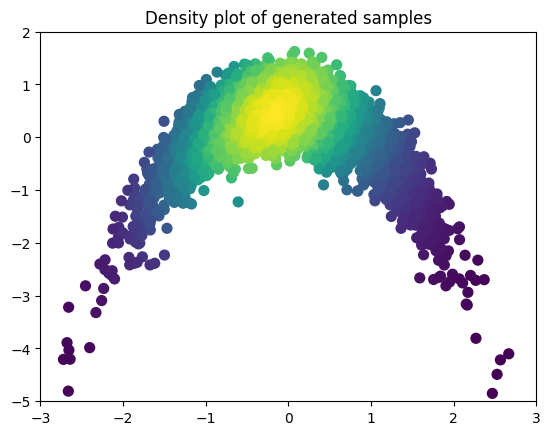

In [11]:
from scipy.stats import gaussian_kde

# Task 3: generate samples from the learned model
# num: number of samples to generate
# model: the trained model


def get_x_t_minus_1(x_t, t, model):
    t_normalized = torch.div(t, T).view(1)

    eps_theta = model(x_t, t_normalized)
    mu_theta = (1 / np.sqrt(1 - beta(t) + 0.01)) * (
        x_t - (beta(t) / np.sqrt(1 - alpha_bar(t))) * eps_theta
    )

    return mu_theta + torch.randn_like(x_t) * np.sqrt(beta(t))


def generate_samples(model, num):
    x_t = torch.normal(0.0, 1.0, size=(num, 2), dtype=torch.float32)
    # arange from T to 1
    t_iter = torch.arange(1, T + 1).flip(dims=(0,))
    for t in t_iter:
        x_t = get_x_t_minus_1(x_t, t, model)
    return x_t


samples = generate_samples(model, 5000).detach().numpy()
plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1], label="truth")
plt.scatter(samples[:, 0], samples[:, 1], label="generated")
plt.ylim(-5, 2)
plt.xlim(-3, 3)
plt.legend()
plt.show()

# Plot densities

# Calculate the point density for truth
xy = np.vstack([Xs[:, 0], Xs[:, 1]])
z = gaussian_kde(xy)(xy)

plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1], c=z, s=50)
plt.title("Density plot of truth")
plt.ylim(-5, 2)
plt.xlim(-3, 3)
plt.show()

# Calculate the point density for generated samples
xy = np.vstack([samples[:, 0], samples[:, 1]])
z = gaussian_kde(xy)(xy)

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=z, s=50)
plt.title("Density plot of generated samples")
plt.ylim(-5, 2)
plt.xlim(-3, 3)
plt.show()